# Tree based methods

In [1]:
# imports
import pandas as pd
import numpy as np
from utils import import_and_transform
from utils import evaluate_model

from sklearn.model_selection import train_test_split
from sklearn.tree import DecisionTreeClassifier
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score, f1_score

from sklearn.ensemble import RandomForestClassifier

from imblearn.over_sampling import SMOTE


## Import data and apply transformations

### Train data

In [2]:
raw_data = pd.read_parquet("Data/train.parquet")

In [3]:
user_data = import_and_transform(raw_data)

Using Dataframe


In [4]:
user_data.head(1)

,status,gender,firstName,level,lastName,userId,ts,auth,page,sessionId,...,userAgent,method,length,song,artist,time,registration,churned,session_length,song_played
0,200,1,Shlok,1,Johnson,1749042,2018-10-01 00:00:01,Logged In,NextSong,22683,...,"""Mozilla/5.0 (Windows NT 6.1; WOW64) AppleWebK...",PUT,524.32934,Ich mache einen Spiegel - Dream Part 4,Popol Vuh,2018-10-01 00:00:01,2018-08-08 13:22:21,1,11405.0,1


### Test data

In [5]:
raw_test_data = pd.read_parquet('Data/test.parquet')

In [6]:
test_data = import_and_transform(raw_test_data)

Using Dataframe


In [7]:
test_data.head(1)


,status,gender,firstName,level,lastName,userId,ts,auth,page,sessionId,...,userAgent,method,length,song,artist,time,registration,churned,session_length,song_played
7,200,1.0,Jonathan,0,Martin,1465194,2018-10-01 00:00:06,Logged In,NextSong,22483,...,"""Mozilla/5.0 (Windows NT 6.1; WOW64) AppleWebK...",PUT,250.8273,Mockingbird,Eminem,2018-10-01 00:00:06,2018-09-27 17:29:36,0,46790.0,1


## Aggregate data

In [8]:
def aggregate1(data: pd.DataFrame):
    user_df = data.groupby('userId').agg({
        'gender': 'first',
        'registration': 'first',
        'level': lambda x: x.mode().iloc[0] if not x.mode().empty else None,
        'sessionId': 'nunique',
        'itemInSession': 'max',
        'ts': ['min', 'max'],
        'session_length': 'mean',
        'song_played': 'sum',
        'artist': pd.Series.nunique,
        'length': 'sum',
        'churned': 'max'    
    }).reset_index()
    
    user_df.columns = ['userId', 'gender', 'registration', 'level',
                       'num_sessions', 'max_item_in_session', 'ts_min', 'ts_max', 
                       'avg_session_length_seconds',  # Renamed for clarity
                       'num_songs_played', 'unique_artists', 'total_length', 'churned']
    
    user_df['days_active'] = (user_df['ts_max'] - user_df['ts_min']).dt.days
    user_df['membership_length'] = (user_df['ts_max'] - user_df['registration']).dt.days
    
    user_df = user_df.fillna(0)
    
    print(f"Processed {len(user_df)} users")
    print(f"Churn rate: {user_df['churned'].mean():.2%}")

    final_column_order = [
            'userId', 'gender', 'registration', 'level',
            'num_sessions', 'max_item_in_session', 'ts_min', 'ts_max',
            'avg_session_length_seconds', 'num_songs_played',
            'unique_artists', 'total_length', 'days_active',
            'membership_length', 'churned'
        ]
    
        
    user_df = user_df[final_column_order]
    user_df.set_index('userId', inplace=True)

    return user_df

In [9]:
def aggregate2(data: pd.DataFrame, observation_end=None):
    """
    Aggregate user-level features for churn prediction.
    
    Args:
        data: Event-level DataFrame
        observation_end: Fixed cutoff date for calculating temporal features.
                        If None, uses the maximum timestamp in the data.
    """
    if observation_end is None:
        observation_end = data['ts'].max()
    else:
        observation_end = pd.Timestamp(observation_end)
    
    user_df = data.groupby('userId').agg({
        'gender': 'first',
        'registration': 'first',
        'level': lambda x: x.mode().iloc[0] if not x.mode().empty else None,
        'sessionId': 'nunique',
        'itemInSession': 'max',
        'ts': ['min', 'max'],
        'session_length': 'mean',
        'song_played': 'sum',
        'artist': pd.Series.nunique,
        'length': 'sum',
        'churned': 'max'    
    }).reset_index()
    
    user_df.columns = ['userId', 'gender', 'registration', 'level',
                       'num_sessions', 'max_item_in_session', 'ts_min', 'ts_max', 
                       'avg_session_length_seconds',
                       'num_songs_played', 'unique_artists', 'total_length', 'churned']
    
    # Fixed temporal features using observation_end
    user_df['days_active'] = (observation_end - user_df['ts_min']).dt.days
    user_df['membership_length'] = (observation_end - user_df['registration']).dt.days
    user_df['days_since_last_activity'] = (observation_end - user_df['ts_max']).dt.days
    
    # Engagement rate features (normalized by time)
    user_df['songs_per_day'] = user_df['num_songs_played'] / (user_df['days_active'] + 1)
    user_df['sessions_per_day'] = user_df['num_sessions'] / (user_df['days_active'] + 1)
    
    user_df = user_df.fillna(0)
    
    print(f"Processed {len(user_df)} users")
    print(f"Churn rate: {user_df['churned'].mean():.2%}")

    final_column_order = [
        'userId', 'gender', 'registration', 'level',
        'num_sessions', 'max_item_in_session', 'ts_min', 'ts_max',
        'avg_session_length_seconds', 'num_songs_played',
        'unique_artists', 'total_length', 'days_active',
        'membership_length', 'days_since_last_activity',
        'songs_per_day', 'sessions_per_day', 'churned'
    ]
    
    user_df = user_df[final_column_order]
    user_df.set_index('userId', inplace=True)

    return user_df

In [57]:
def aggregate3(data: pd.DataFrame, observation_end=None):
    """
    Aggregate user-level features for churn prediction.
    
    Args:
        data: Event-level DataFrame
        observation_end: Fixed cutoff date for calculating temporal features.
                        If None, uses the maximum timestamp in the data.
    """
    if observation_end is None:
        observation_end = data['ts'].max()
    else:
        observation_end = pd.Timestamp(observation_end)
    
    user_df = data.groupby('userId').agg({
        'gender': 'first',
        'registration': 'first',
        'level': lambda x: x.mode().iloc[0] if not x.mode().empty else None,
        'sessionId': 'nunique',
        'itemInSession': ['max', 'mean'],  # Added mean
        'ts': ['min', 'max'],
        'session_length': ['mean', 'std', 'max'],  # Added std and max
        'song_played': 'sum',
        'artist': pd.Series.nunique,
        'length': ['sum', 'mean'],  # Added mean song length
        'churned': 'max'    
    }).reset_index()
    
    user_df.columns = ['userId', 'gender', 'registration', 'level',
                       'num_sessions', 'max_item_in_session', 'avg_item_in_session',
                       'ts_min', 'ts_max', 
                       'avg_session_length_seconds', 'std_session_length', 'max_session_length',
                       'num_songs_played', 'unique_artists', 'total_length', 'avg_song_length',
                       'churned']
    
    # Temporal features
    user_df['days_active'] = (observation_end - user_df['ts_min']).dt.days
    user_df['membership_length'] = (observation_end - user_df['registration']).dt.days
    user_df['days_since_last_activity'] = (observation_end - user_df['ts_max']).dt.days
    
    # Engagement rate features
    user_df['songs_per_day'] = user_df['num_songs_played'] / (user_df['days_active'] + 1)
    user_df['sessions_per_day'] = user_df['num_sessions'] / (user_df['days_active'] + 1)
    user_df['songs_per_session'] = user_df['num_songs_played'] / (user_df['num_sessions'] + 1)
    
    # Diversity and exploration metrics
    user_df['artist_diversity_ratio'] = user_df['unique_artists'] / (user_df['num_songs_played'] + 1)
    user_df['avg_listening_time_per_day'] = user_df['total_length'] / (user_df['days_active'] + 1)
    
    # Recency metric (proportion of membership spent inactive)
    user_df['inactivity_ratio'] = user_df['days_since_last_activity'] / (user_df['membership_length'] + 1)
    
    # Session variability (high std might indicate inconsistent engagement)
    user_df['session_length_cv'] = user_df['std_session_length'] / (user_df['avg_session_length_seconds'] + 1)
    
    user_df = user_df.fillna(0)
    
    print(f"Processed {len(user_df)} users")
    print(f"Churn rate: {user_df['churned'].mean():.2%}")

    final_column_order = [
        'userId', 'gender', 'registration', 'level',
        'num_sessions', 'max_item_in_session', 'avg_item_in_session',
        'ts_min', 'ts_max',
        'avg_session_length_seconds', 'std_session_length', 'max_session_length',
        'num_songs_played', 'unique_artists', 'total_length', 'avg_song_length',
        'days_active', 'membership_length', 'days_since_last_activity',
        'songs_per_day', 'sessions_per_day', 'songs_per_session',
        'artist_diversity_ratio', 'avg_listening_time_per_day',
        'inactivity_ratio', 'session_length_cv', 'churned'
    ]
    
    user_df = user_df[final_column_order]
    user_df.set_index('userId', inplace=True)

    return user_df

In [58]:
aggregate = aggregate3
agg_data = aggregate(user_data)
agg_test_data = aggregate(test_data)

Processed 19140 users
Churn rate: 22.31%
Processed 2904 users
Churn rate: 0.00%


In [11]:
agg_data.head(1)

,gender,registration,level,num_sessions,max_item_in_session,ts_min,ts_max,avg_session_length_seconds,num_songs_played,unique_artists,total_length,days_active,membership_length,days_since_last_activity,songs_per_day,sessions_per_day,churned
userId,,,,,,,,,,,,,,,,,
1000025,1,2018-07-10 09:30:08,1,17,486,2018-10-02 08:59:29,2018-10-18 20:33:05,49322.882294,1662,1162,417296.59169,48,132,32,33.918367,0.346939,1


In [12]:
agg_test_data.head(1)

,gender,registration,level,num_sessions,max_item_in_session,ts_min,ts_max,avg_session_length_seconds,num_songs_played,unique_artists,total_length,days_active,membership_length,days_since_last_activity,songs_per_day,sessions_per_day,churned
userId,,,,,,,,,,,,,,,,,
1000655,0.0,2018-09-14 11:53:55,0,10,178,2018-10-03 09:00:59,2018-11-15 18:14:51,18280.601156,262,239,65479.8747,47,66,4,5.458333,0.208333,0


In [59]:
X_drop_cols = ['churned', 'registration', 'ts_min', 'ts_max', 'total_length']
X = agg_data.drop(columns=X_drop_cols)
y = agg_data['churned']
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42, stratify=y
)

test_set_X = agg_test_data.drop(columns=X_drop_cols)

## Testing out different models

### Decision Tree Classifier

In [40]:
clf = DecisionTreeClassifier(class_weight='balanced', max_depth=10, random_state=42)
clf.fit(X_train, y_train)

# 6. Evaluate
y_pred = clf.predict(X_test)

print("Accuracy:", accuracy_score(y_test, y_pred))
print("\nConfusion Matrix:\n", confusion_matrix(y_test, y_pred))
print("\nClassification Report:\n", classification_report(y_test, y_pred))

evaluate_model(clf, test_set_X, file_out="submission-dt.csv")

Accuracy: 0.8085161964472309

Confusion Matrix:
 [[2490  484]
 [ 249  605]]

Classification Report:
               precision    recall  f1-score   support

           0       0.91      0.84      0.87      2974
           1       0.56      0.71      0.62       854

    accuracy                           0.81      3828
   macro avg       0.73      0.77      0.75      3828
weighted avg       0.83      0.81      0.82      3828

Base predicted churn: 11.88%
<class 'NoneType'>
Submission saved to submission-dt.csv


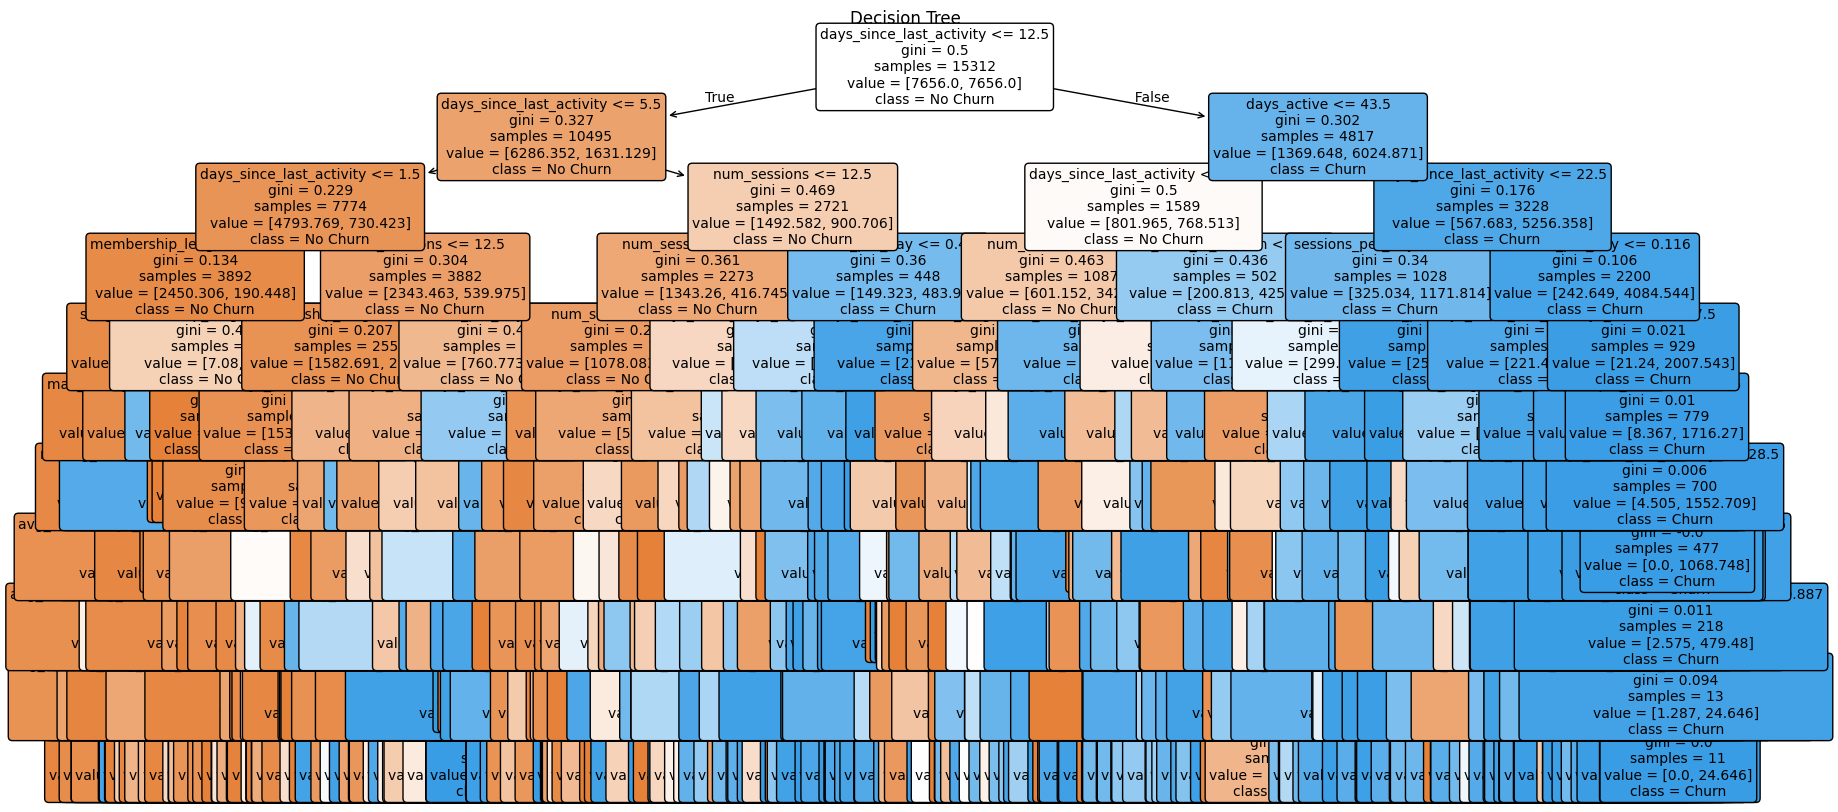

In [20]:
from sklearn.tree import plot_tree
import matplotlib.pyplot as plt

plt.figure(figsize=(20, 10))
plot_tree(
    clf,                        # your trained DecisionTreeClassifier
    feature_names=X_train.columns,
    class_names=["No Churn", "Churn"],
    filled=True,
    rounded=True,
    fontsize=10
)
plt.title("Decision Tree")
plt.show()

### XGBoost

In [22]:
import xgboost as xgb
neg, pos = (y_train == 0).sum(), (y_train == 1).sum()
scale_ratio = neg / pos

clf = xgb.XGBClassifier(
    scale_pos_weight=scale_ratio,  # handles imbalance
    objective='binary:logistic',
    eval_metric='logloss',
    use_label_encoder=False,
    n_estimators=100,
    max_depth=5,
    learning_rate=0.1,
    random_state=42
)

clf.fit(X_train, y_train)

y_pred = clf.predict(X_test)

print("Confusion Matrix:\n", confusion_matrix(y_test, y_pred))
print("\nClassification Report:\n", classification_report(y_test, y_pred))
print("F1 Score:", f1_score(y_test, y_pred))

evaluate_model(clf, test_set_X, file_out='submission-xgb.csv')

Confusion Matrix:
 [[2703  271]
 [ 164  690]]

Classification Report:
               precision    recall  f1-score   support

           0       0.94      0.91      0.93      2974
           1       0.72      0.81      0.76       854

    accuracy                           0.89      3828
   macro avg       0.83      0.86      0.84      3828
weighted avg       0.89      0.89      0.89      3828

F1 Score: 0.7603305785123967
Base predicted churn: 6.82%
<class 'NoneType'>
Submission saved to submission-xgb.csv


C:\Users\Martin\Documents\X HEC\env\lib\site-packages\xgboost\training.py:199: UserWarning: [13:33:51] WARNING: C:\actions-runner\_work\xgboost\xgboost\src\learner.cc:790: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)


### RandomForest

In [60]:
clf = RandomForestClassifier(class_weight='balanced', max_depth=10, n_estimators=100, random_state=42)
clf.fit(X_train, y_train)

# 6. Evaluate
y_pred = clf.predict(X_test)

print("Accuracy:", accuracy_score(y_test, y_pred))
print("\nConfusion Matrix:\n", confusion_matrix(y_test, y_pred))
print("\nClassification Report:\n", classification_report(y_test, y_pred))



Accuracy: 0.8973354231974922

Confusion Matrix:
 [[2775  199]
 [ 194  660]]

Classification Report:
               precision    recall  f1-score   support

           0       0.93      0.93      0.93      2974
           1       0.77      0.77      0.77       854

    accuracy                           0.90      3828
   macro avg       0.85      0.85      0.85      3828
weighted avg       0.90      0.90      0.90      3828



In [70]:
evaluate_model(model=clf, test_set=test_set_X, p=0.14, file_out='submission-rf-014.csv')

Base predicted churn: 5.03%
<class 'float'>
Predicted churn at 0.14 threshold: 34.85%
Submission saved to submission-rf-014.csv


In [ ]:
smote = SMOTE(random_state=42)
X_train_resampled, y_train_resampled = smote.fit_resample(X_train, y_train)

# Check the new class distribution
print(f"Original training set: {y_train.value_counts().to_dict()}")
print(f"Resampled training set: {y_train_resampled.value_counts().to_dict()}")

# Train on resampled data
clf = RandomForestClassifier(
    max_depth=10, 
    n_estimators=100, 
    random_state=42
)
clf.fit(X_train_resampled, y_train_resampled)

# Evaluate on original test set (never resample test data!)
y_pred = clf.predict(X_test)
y_proba = clf.predict_proba(X_test)[:, 1]

print("F1 Score:", f1_score(y_test, y_pred))
print("\nConfusion Matrix:\n", confusion_matrix(y_test, y_pred))
print("\nClassification Report:\n", classification_report(y_test, y_pred))

evaluate_model(model=clf, test_set=test_set_X, file_out='submission-rf-smt.csv')

### CatBoost

In [52]:
from imblearn.over_sampling import SMOTE
from catboost import CatBoostClassifier
from sklearn.metrics import classification_report, confusion_matrix, f1_score, roc_auc_score

# Apply SMOTE to training data
smote = SMOTE(random_state=42)
X_train_resampled, y_train_resampled = smote.fit_resample(X_train, y_train)

print(f"Original training set: {y_train.value_counts().to_dict()}")
print(f"Resampled training set: {y_train_resampled.value_counts().to_dict()}")

# Train CatBoost on resampled data
clf = CatBoostClassifier(
    iterations=100,
    depth=6,
    learning_rate=0.1,
    random_state=42,
    verbose=False
    # Note: removed auto_class_weights since SMOTE balanced the classes
)

# If you have categorical features, specify them
# cat_features = ['gender', 'level']  # column names or indices
# clf.fit(X_train_resampled, y_train_resampled, cat_features=cat_features)

clf.fit(X_train, y_train)

# Evaluate on original test set
y_pred = clf.predict(X_test)
y_proba = clf.predict_proba(X_test)[:, 1]

print("F1 Score:", f1_score(y_test, y_pred))
print("ROC-AUC:", roc_auc_score(y_test, y_proba))
print("\nConfusion Matrix:\n", confusion_matrix(y_test, y_pred))
print("\nClassification Report:\n", classification_report(y_test, y_pred))



Original training set: {0: 11895, 1: 3417}
Resampled training set: {1: 11895, 0: 11895}
F1 Score: 0.7698209718670077
ROC-AUC: 0.9254125134459618

Confusion Matrix:
 [[2866  108]
 [ 252  602]]

Classification Report:
               precision    recall  f1-score   support

           0       0.92      0.96      0.94      2974
           1       0.85      0.70      0.77       854

    accuracy                           0.91      3828
   macro avg       0.88      0.83      0.86      3828
weighted avg       0.90      0.91      0.90      3828



In [56]:
evaluate_model(model=clf, test_set=test_set_X, p=0.04, file_out='submission-catb.csv')


Base predicted churn: 2.24%
<class 'float'>
Predicted churn at 0.04 threshold: 49.52%
Submission saved to submission-catb.csv
